In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.lines import Line2D

sns.set(font_scale=2)
sns.set_style("ticks")

In [2]:
demographics_data = pd.read_csv("data/Questionnaire/demographics.csv")
demographics_data.columns = ["Participant", "Sex", "Age", "Familiarity", "Attitude"]
demographics_data["Experience"] = "Videos"
demographics_data.loc[demographics_data["Familiarity"] > 3, "Experience"] = "In-person" 
demographics_data["attitude_q"] = pd.cut(demographics_data.Attitude, 2, labels=["Negative", "Positive"])

data = pd.read_csv("data/Questionnaire/Questionnaire_responses.csv")
data = data.replace("Fronting", "Head-on")
data_long = pd.melt(data, id_vars=["Scenario", "Appearance", "Feeling"], var_name='Participant', value_name='Rating')
data_long["Participant"] = data_long["Participant"].astype(int)

data_wide = data_long.pivot(index=['Participant', 'Scenario', 'Appearance'], columns='Feeling', values='Rating')
full_data = data_long.join(demographics_data.set_index("Participant"), on="Participant")

participants = full_data.groupby("Participant")[["Rating"]].mean()
participants = participants.join(demographics_data.set_index("Participant"), on="Participant")
data_long = data_long.join(participants["Experience"], on="Participant", how="left")

In [3]:
participants.to_csv("data/processed/participants.csv")

In [4]:
participants

,Rating,Sex,Age,Familiarity,Attitude,Experience,attitude_q
Participant,,,,,,,
1,3.40625,M,26,5,4,In-person,Positive
2,2.96875,M,27,3,4,Videos,Positive
3,3.03125,M,26,4,4,In-person,Positive
4,2.84375,M,26,4,1,In-person,Negative
5,3.46875,M,30,4,4,In-person,Positive
6,3.50000,M,23,3,5,Videos,Positive
7,4.09375,M,34,4,4,In-person,Positive
8,3.71875,M,27,5,5,In-person,Positive
9,3.15625,F,26,3,3,Videos,Negative


# Demographics overview

In [5]:
demographics_data

,Participant,Sex,Age,Familiarity,Attitude,Experience,attitude_q
0,1,M,26,5,4,In-person,Positive
1,2,M,27,3,4,Videos,Positive
2,3,M,26,4,4,In-person,Positive
3,4,M,26,4,1,In-person,Negative
4,5,M,30,4,4,In-person,Positive
5,6,M,23,3,5,Videos,Positive
6,7,M,34,4,4,In-person,Positive
7,8,M,27,5,5,In-person,Positive
8,9,F,26,3,3,Videos,Negative
9,10,O,28,4,4,In-person,Positive


In [6]:
demographics_data.groupby("Sex").size()

Sex
F     7
M    13
O     1
dtype: int64

In [7]:
print(demographics_data.Age.mean(), demographics_data.Age.std())

27.857142857142858 4.819602828923918


In [8]:
demographics_data.groupby("Familiarity").size()

Familiarity
3    10
4     9
5     2
dtype: int64

In [9]:
demographics_data["Attitude"].mean()

3.6666666666666665

Text(0, 0.5, 'Count')

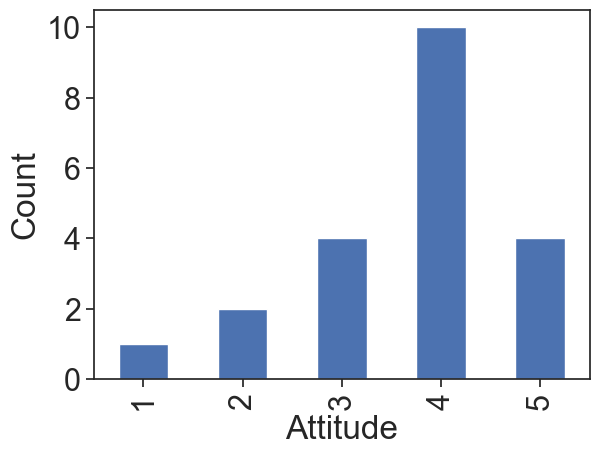

In [10]:
ax = demographics_data["Attitude"].value_counts().sort_index().plot(kind="bar")
ax.set_ylabel("Count")

# Perception questionnaires

## ANOVA

In [11]:
model = ols(
    'Rating ~ C(Scenario) * C(Appearance) * C(Experience)', data=data_long).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Scenario),11.263393,1.0,11.055385,0.000933
C(Appearance),12.870536,1.0,12.632848,0.000406
C(Experience),4.837716,1.0,4.748376,0.029677
C(Scenario):C(Appearance),0.537202,1.0,0.527282,0.468008
C(Scenario):C(Experience),2.739448,1.0,2.688857,0.101526
C(Appearance):C(Experience),0.355032,1.0,0.348476,0.555178
C(Scenario):C(Appearance):C(Experience),0.152002,1.0,0.149195,0.699430
Residual,676.493182,664.0,NaN,NaN


## Plots

D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\source\Spot-DataAnalysis\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

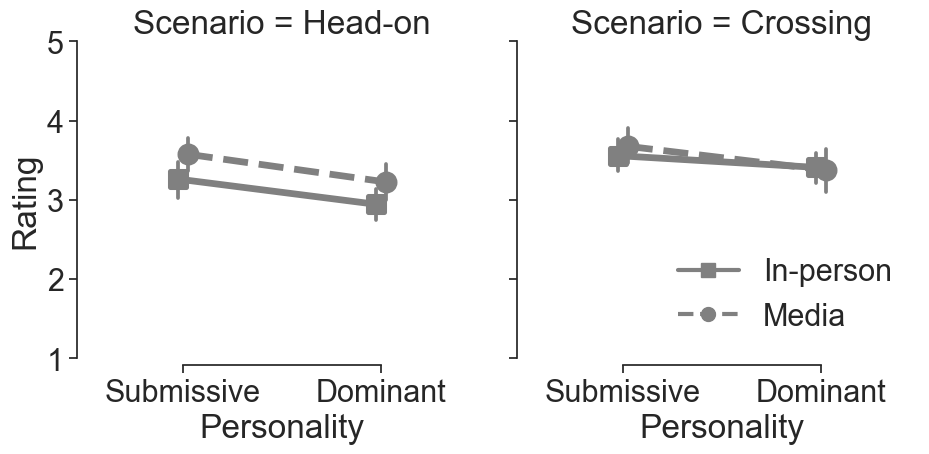

In [12]:
g = sns.catplot(data=data_long.rename(columns={"Appearance": "Personality"}).replace("Videos", "Media"), 
                y="Rating", x="Personality", col="Scenario", hue="Experience", kind="point", dodge=True, scale=1.8, markers=["s", "o"], palette=["grey", "grey"], legend=False)
(ax1, ax2) = g.axes.flatten()
ax1.lines[3].set_linestyle("--")
ax2.lines[3].set_linestyle("--")
ax1.set_ylim((1, 5))
ax2.set_ylim((1, 5))

legend_elements = [Line2D([], [], color="grey", marker="s", ms=10, lw=3, ls="-", label="In-person"), 
                   Line2D([], [], color="grey", marker="o", ms=10, lw=3, ls="--", label="Media")]
ax2.legend(handles=legend_elements, frameon=False, loc="lower right")

sns.despine(offset=5, trim=True)
plt.savefig("output/perception_appearance_experience.png", bbox_inches="tight", dpi=300)

## t-tests

In [13]:
data_long[data_long.Appearance=="Submissive"].Rating.mean(), data_long[data_long.Appearance=="Dominant"].Rating.mean()

(3.511904761904762, 3.2351190476190474)

In [14]:
scipy.stats.ttest_rel(data_long[data_long.Appearance=="Submissive"].Rating, data_long[data_long.Appearance=="Dominant"].Rating)

TtestResult(statistic=4.546036246269203, pvalue=7.64650225782735e-06, df=335)

In [15]:
data_long[data_long.Experience=="In-person"].Rating.mean(), data_long[data_long.Experience=="Videos"].Rating.mean()

(3.2926136363636362, 3.4625)

In [16]:
scipy.stats.ttest_ind(data_long[data_long.Experience=="In-person"].Rating, data_long[data_long.Experience=="Videos"].Rating)

TtestResult(statistic=-2.145085487419647, pvalue=0.03230487882497948, df=670.0)

In [17]:
data_long[data_long.Scenario=="Crossing"].Rating.mean(), data_long[data_long.Scenario=="Head-on"].Rating.mean()

(3.5029761904761907, 3.244047619047619)

In [18]:
scipy.stats.ttest_rel(data_long[data_long.Scenario=="Head-on"].Rating, data_long[data_long.Scenario=="Crossing"].Rating)

TtestResult(statistic=-5.772495399239405, pvalue=1.7809904284727847e-08, df=335)